In [1]:
import json
import pandas as pd
import os
from typing import List
from datetime import datetime
import re

In [2]:
ML_JOB_PATH = "Machine-learning-engineer-jobs20230105152444.jsonl"
DS_JOB_PATH = "Data-scientist-jobs20230105145838.jsonl"

RANDOM_STATE = 42

In [3]:
def validate_data_path(data_path:str):
    """Validates data path

    Args:
        data_path (str): path of the data

    Raises:
        FileNotFoundError: File does not exist
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(data_path)

In [4]:
# not all data point is perfect, for those with errors I will ignore

def return_data(data_path:str)->List:
    """Returns job detail from on job posting

    Args:
        data_path (str): Path of the data

    Returns:
        List: A list full of the job posting, each a dictionary
    """
    validate_data_path(data_path)
    data_list = []
    with open(data_path, 'r') as reader:
        for line in reader.readlines():
            data = json.loads(line)
            # Errors are only contained in the dictionary
            if isinstance(data,dict):
                continue
            data_list.append(data)
    return data_list

In [5]:
ML_JOB_RAW_DATA = return_data(ML_JOB_PATH)
DS_JOB_RAW_DATA = return_data(DS_JOB_PATH)

In [6]:
len(ML_JOB_RAW_DATA)

580

In [7]:
len(DS_JOB_RAW_DATA)

577

In [8]:
TOTAL_JOB_RAW_DATA = ML_JOB_RAW_DATA + DS_JOB_RAW_DATA

In [9]:
TOTAL_JOB_RAW_DATA[0][2]

{'small_section': ['Singapore', 'Posted 19 hours ago']}

We have a total of 1157 data points

In [10]:
len(TOTAL_JOB_RAW_DATA)

1157

In [11]:
def return_headers()->dict:
    """ 
    Attempting to fetch headers from their respective cols with the col index appended
    returns a dictionary with the count of the header as the value
    """
    headers = {}
    for row in TOTAL_JOB_RAW_DATA:
        for col in range(1,len(row)):
            for key in row[col].keys():
                if str(key) + '_' + str(col) in headers:
                    headers[f"{key}_{col}"] +=1
                else: 
                    headers[f"{key}_{col}"] = 1
    return headers

In [12]:
headers = return_headers()

In [13]:
len(headers)

746

In [14]:
# This is a slice of all of the headers found coz otherwise it will be too big
headers_slice = {k:headers[k] for k in list(headers)[:15]}

In [15]:
headers_slice

{'company_name_1': 1157,
 'small_section_2': 1157,
 'Responsibilities_3': 544,
 'Why Join Us_3': 35,
 'Responsibilities:_3': 129,
 'Qualifications:_3': 108,
 'Career Level_4': 1157,
 'Qualification_4': 1157,
 'Years of Experience_4': 971,
 'Job Type_4': 1157,
 'Job Specializations_4': 1157,
 'Registration No._4': 1149,
 'Company Size_4': 1151,
 'Average Processing Time_4': 1070,
 'Industry_4': 1152}

These headers have values for all jobs

In [16]:
full_header = [k for k,v in headers.items() if v == len(TOTAL_JOB_RAW_DATA)]
full_header

['company_name_1',
 'small_section_2',
 'Career Level_4',
 'Qualification_4',
 'Job Type_4',
 'Job Specializations_4',
 'Company Overview_5',
 'url_6']

I am expecting all information to be filled in:
- First col: Job position (renamed as job title)
- Second col: Details of the job including pay, location (General and or specific), 
- Fourth col: Misc details of the company including size of company, dress code etc
- Fifth col: Company Overview, details on the company
- Sixth col: URL

Within the second col I expect there are also some headers to be further broken down. 

The largest one will have to be the second col with the job description being the most variable component of the posting. I suspect most of the work will be done in here to uncover as much information as possible.

The desired outcome will be a consolidated pandas dataframe with as little information loss as possible.

# Preprocess

| Idx | Col |
| --- | --- |
| 0 | position |
| 1 | company name |
| 2 | small_section |
| 3 | JD |
| 4 | additional information |
| 5 | Company Overview |
| 6 | url |

## Full Columns

In [17]:
# We do see some artifacts in the job titles like
# - Job reference number
# - Hashtags

job_reference_pattern = r"\(?\w+\d+\)?"
hashtag_pattern = r"#\w+"

data = {}
job_title,company_name,career_level,job_type, job_specialisations, \
    url, qualification, company_overview = [],[],[],[],[],[],[],[]
for row in TOTAL_JOB_RAW_DATA:
    position = row[0]['position']
    position = re.sub(job_reference_pattern, "",position)
    position = re.sub(hashtag_pattern, "",position)
    position = position.replace("*","").replace("-","")
    job_title.append(position)
    company_name.append(row[1]['company_name'])
    career_level.append(row[4]['Career Level'])
    qualification.append(row[4]['Qualification'])
    job_type.append(row[4]['Job Type'])
    job_specialisations.append(row[4]['Job Specializations'])
    company_overview.append(row[5]['Company Overview'])
    url.append(row[6]['url'])

data['position'] = job_title
data['company_name'] = company_name
data['career_level'] = career_level
data['qualifcation'] = qualification
data['job_type'] = job_type
data['job_specialisations'] = job_specialisations
data['company_overview'] = company_overview
data['url'] = url

assert (len(job_title) == len(career_level)==len(job_type)==len(job_specialisations)==len(url))

In [18]:
# Already we can see some field contains some other information like the job_title containing job type, location and company name for instance
pd.DataFrame.from_dict(data).tail()

,position,company_name,career_level,qualifcation,job_type,job_specialisations,company_overview,url
1152,Research Assistant (Governance) for AI Singapore,National University of Singapore,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Contract,"Education/Training, Education",\n\tA leading global university centred in Asi...,http://www.jobstreet.com.sg/en/job/research-as...
1153,Data Science Team Lead,Government Technology Agency of Singapore (Gov...,Senior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",\n\n\t\tThe Government Technology Agency (GovT...,http://www.jobstreet.com.sg/en/job/data-scienc...
1154,"Manager, Audit Analytics. '",ALLEGIS GLOBAL SOLUTIONS (SINGAPORE) PTE. LTD,Manager,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Accounting/Finance, Audit & Taxation",\n\n\t\tAllegis Global Solutions is the exclus...,http://www.jobstreet.com.sg/en/job/manager-aud...
1155,Data Scientist Research,TikTok,Junior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bac...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/data-scient...
1156,Data ScientistAlgorithm Strategy,TikTok,Junior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bac...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/data-scient...


In [19]:
pd.DataFrame.from_dict(data).sample(15, random_state=RANDOM_STATE)

,position,company_name,career_level,qualifcation,job_type,job_specialisations,company_overview,url
940,"Snr Specialist Biz Transformation, Data Migration",ASM Front-End Manufacturing Singapore Pte Ltd,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Network/Sy...","\n\tIn 1968, at the very outset of the global ...",http://www.jobstreet.com.sg/en/job/snr-special...
265,AI Architect (Digital),Mediacorp Pte Ltd,Senior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bac...",Full-Time,"Computer/Information Technology, IT-Software",\n\nMediacorp is Singapore’s leading media com...,http://www.jobstreet.com.sg/en/job/ai-architec...
109,"Machine Learning Engr., TikTok Search",TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/machine-lea...
299,"Machine Learning Engineer, TikTok",TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/machine-lea...
752,Data Administator,SELF HELP GROUPS STUDENT CARE LIMITED,Junior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bac...",Full-Time,"Computer/Information Technology, IT-Network/Sy...",The Self Help Groups Student Care Limited (SHG...,http://www.jobstreet.com.sg/en/job/data-admini...
170,Machine Learning Engineer (TikTok) Start,TikTok,Entry Level,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/machine-lea...
887,"IBOR Programme, Data Analytics Reg Reporting..",ALLEGIS GLOBAL SOLUTIONS (SINGAPORE) PTE. LTD,Senior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",\n\n\t\tAllegis Global Solutions is the exclus...,http://www.jobstreet.com.sg/en/job/ibor-progra...
549,"AIOps Algorithm Engineer, Applications Perform...",TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/aiops-algor...
943,Data Scientist ECommerce Risk Control #.,TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Prof...",Full-Time,"Computer/Information Technology, IT-Software",TikTok is the leading destination for short-fo...,http://www.jobstreet.com.sg/en/job/data-scient...
597,Data Scientist risk control GGLL,PERSOLKELLY Singapore Pte Ltd (Formerly Kelly ...,Senior Executive,Not Specified,Full-Time,"Computer/Information Technology, IT-Software",PERSOLKELLY is one of the largest recruitment ...,http://www.jobstreet.com.sg/en/job/data-scient...


## Partial Columns

### Small Section

This is where the trouble/fun starts. Lets start with the small section


In [20]:
# The small section contains a list with location, salary (if available) and then post date
for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
    if idx > 20 :
        break
    else:
        print(row[2])

{'small_section': ['Singapore', 'Posted 19 hours ago']}
{'small_section': ['Singapore', 'Posted 21 hours ago']}
{'small_section': ['Singapore', 'Posted 23 hours ago']}
{'small_section': ['Singapore', 'Posted 18 hours ago']}
{'small_section': ['Singapore', 'SGD\xa07,000 - SGD\xa09,000', 'Posted 3 hours ago']}
{'small_section': ['Singapore', 'Posted 11 minutes ago']}
{'small_section': ['Singapore', 'Posted 3 hours ago']}
{'small_section': ['Singapore', 'Posted 2 hours ago']}
{'small_section': ['West', 'SGD\xa05,000 - SGD\xa08,000', 'Posted on 3-Jan-23']}
{'small_section': ['Singapore', 'Posted 21 hours ago']}
{'small_section': ['Singapore', 'Posted 53 minutes ago']}
{'small_section': ['Singapore', 'Posted 4 hours ago']}
{'small_section': ['Singapore', 'Posted on 3-Jan-23']}
{'small_section': ['Singapore', 'Posted 19 hours ago']}
{'small_section': ['Singapore', 'Posted on 3-Jan-23']}
{'small_section': ['Singapore', 'SGD\xa05,000 - SGD\xa07,000', 'Posted 22 hours ago']}
{'small_section': [

Contains either
- location , salary (optional), date of posting

In [21]:
demo = 'Posted on 5-Jan-23'

In [22]:
demo.split("Posted on")[1].strip()

'5-Jan-23'

In [23]:
datetime.strptime(demo.split("Posted on")[1].strip(),'%d-%b-%y')

datetime.datetime(2023, 1, 5, 0, 0)

In [24]:
ML_JOB_PATH

'Machine-learning-engineer-jobs20230105152444.jsonl'

In [25]:
curr_date = ML_JOB_PATH[-20:-12]

In [26]:
curr_date

'20230105'

In [27]:
datetime.strptime(curr_date, '%Y%m%d').year

2023

In [28]:
def extract_date_from_posted_date(sample_text:str, file_path:str)->datetime:
    """Return posted date in datetime format

    Args:
        sample_text (str): sample text from the row
        file_path (str): File path from the data in jsonl format
        to determine the current date

    Returns:
        datetime: When the job was posted
    """
    if 'on' in sample_text:
        sample_date = sample_text.split("Posted on")[1].strip()
        return datetime.strptime(sample_date,'%d-%b-%y')
    else:
        curr_date = file_path[-20:-12]
        return datetime.strptime(curr_date, '%Y%m%d')

In [29]:
# For location, we will take in anything that is other than Singapore, if Singapore we will leave it as unspecified
# For Salary, we will clean up the html artifact '\xa0' and seperate into low to high
# For Post date, we will just take in as is. Any variant of Posted on xxx will be tagged as the date of extraction which is collected on the jsonl file

location, low_salary, high_salary, post_date = [],[],[],[]

curr_date = ML_JOB_PATH[-20:-12]

for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
    select_row = row[2]['small_section']
    # location
    try:
        # There are instances where no location is entered 
        if select_row[0] is not None: 
            if 'sin' not in select_row[0].lower():
                location.append(select_row[0])
            else:
                location.append('unspecified')    
        else:
            location.append('unspecified')
        # check for salary, otherwise its posted date
        if 'sgd' in select_row[1].lower():
            if "\xa0" in select_row[1].lower():
                low_salary.append(select_row[1].split("\xa0")[1].split('-')[0].strip())
                high_salary.append(select_row[1].split("\xa0")[2].strip())
            else:
                salary = select_row[1].lower().split('sgd')[1].strip()
                low_salary.append(salary)
                high_salary.append(salary)
        # if sgd not in this value, it must be posted date, salary
        # is then populated with unspecified
        else:
            salary = 'unspecified'
            low_salary.append(salary)
            high_salary.append(salary)
            post_date.append(extract_date_from_posted_date(select_row[1], ML_JOB_PATH))
        # if third value is present, it must be posted date
        if len(select_row) == 3:
            post_date.append(extract_date_from_posted_date(select_row[1], ML_JOB_PATH))
    except Exception as e:
        print(f"{idx} with {row} has issue {e}")

assert (len(location)==len(low_salary)==len(high_salary)==len(post_date))

In [30]:
data['location'] = location
data['low_salary'] = low_salary
data['high_salary'] = high_salary
data['post_date'] = post_date

In [31]:
pd.set_option('max_colwidth', 400)

In [32]:
# This is how the dataframe looks like so far.
pd.DataFrame.from_dict(data).sample(15,random_state=RANDOM_STATE)

,position,company_name,career_level,qualifcation,job_type,job_specialisations,company_overview,url,location,low_salary,high_salary,post_date
940,"Snr Specialist Biz Transformation, Data Migration",ASM Front-End Manufacturing Singapore Pte Ltd,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Professional Degree",Full-Time,"Computer/Information Technology, IT-Network/Sys/DB Admin","\n\tIn 1968, at the very outset of the global semiconductor industry, entrepreneur Arthur del Prado established ASM in the Netherlands. Mr Del Prado then served as President, Chief Executive Officer and Chairman of the Management Board of ASM International until his retirement, in 2008. Acclaimed as the ""father of the European semiconductor equipment industry”, his contributions to the industr...",http://www.jobstreet.com.sg/en/job/snr-specialist-biz-transformation-data-migration-10270617?jobId=jobstreet-sg-job-10270617&sectionRank=377&token=0~9232a8db-1b04-45af-a55b-b7ddd2a5f148&fr=SRP%20Job%20Listing,unspecified,unspecified,unspecified,2022-12-21
265,AI Architect (Digital),Mediacorp Pte Ltd,Senior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Software","\n\nMediacorp is Singapore’s leading media company with the most complete range of platforms, spanning television, radio, newspapers, magazines, movies, digital and out-of-home media.\n\t\t \n\n\t\tIt pioneered the development of Singapore’s broadcasting industry, with the broadcast of Radio in 1936 and Television in 1963.\n\n\t\tToday, Mediacorp has over 50 products and brands in four languag...",http://www.jobstreet.com.sg/en/job/ai-architect-digital-10232479?jobId=jobstreet-sg-job-10232479&sectionRank=276&token=0~028e1606-4f5f-41e8-a322-949f17f3c36b&fr=SRP%20Job%20Listing,unspecified,unspecified,unspecified,2022-12-17
109,"Machine Learning Engr., TikTok Search",TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Software","TikTok is the leading destination for short-form mobile video. Our mission is to inspire creativity and bring joy. TikTok is a global short-form mobile video platform that allows you to express yourself by creating content. It gives rise to engaging, interactive challenges and trending topics in which anyone can participate. TikTok aims to capture and showcase the world's creativity, knowledge...",http://www.jobstreet.com.sg/en/job/machine-learning-engr.-tiktok-search-urgent-worknow-10308024?jobId=jobstreet-sg-job-10308024&sectionRank=114&token=0~2d20fa49-9650-4bbc-b087-8815b24611d8&fr=SRP%20Job%20Listing,unspecified,unspecified,unspecified,2023-01-05
299,"Machine Learning Engineer, TikTok",TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Software","TikTok is the leading destination for short-form mobile video. Our mission is to inspire creativity and bring joy. TikTok is a global short-form mobile video platform that allows you to express yourself by creating content. It gives rise to engaging, interactive challenges and trending topics in which anyone can participate. TikTok aims to capture and showcase the world's creativity, knowledge...",http://www.jobstreet.com.sg/en/job/machine-learning-engineer-tiktok-urgent-10257908?jobId=jobstreet-sg-job-10257908&sectionRank=311&token=0~227ba018-ed7c-4e6e-b992-f50ffce511ff&fr=SRP%20Job%20Listing,unspecified,unspecified,unspecified,2022-12-17
752,Data Administator,SELF HELP GROUPS STUDENT CARE LIMITED,Junior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Network/Sys/DB Admin","The Self Help Groups Student Care Limited (SHGSCL) is a joint venture company owned by

### Job description

Because this section is pretty much is an open format for text to be dumped, the rationale for the scrapping rules is that it would be easier to identify actual JDs as they tend to be encapsulated in list format preceded by a header in bold. Of course the actual JD could be contained in some other format however this is one way to remove extra information like standard clauses by companies.  

Remove the _3 suffix attached to the key

In [33]:
def return_jd_headers_count():
    headers = return_headers()
    jd_headers = {key[:-2]:headers[key] for key in list(headers) if key.endswith('3')}

    return jd_headers

In [34]:
jd_headers = return_jd_headers_count()

In [35]:
len(jd_headers)

730

In [36]:
sorted_jd_headers = dict(sorted(jd_headers.items(), key=lambda item: item[1], reverse=True))

In this instance we see most of them are captured under expected headers like Job requirements, responsibilites, requirements and similar variants 20 shown only for visibility

In [37]:
{key:sorted_jd_headers[key] for key in list(sorted_jd_headers)[:10]}

{'Responsibilities': 544,
 'Qualifications': 470,
 'Responsibilities:': 129,
 'Qualifications:': 108,
 'Preferred Qualifications': 92,
 'Our Ideal Candidate': 80,
 'Job Description': 68,
 'Requirements': 67,
 'unorganised_jd': 67,
 'no_header_JD': 60}

I imagine JDs would then have two sections:
- the Actual Job description, this includes the duties, the actual job description
- Their requirements in a candidate, qualifications ,etc

My next approach is to gather all of the headers that correspond to those two categories and fill them up with values.
The difficulty here is that there is no consistent format for the companies or posters to list them unlike the previous categories. Taking the whole information and dumping them in one category or sieving them is also a big problem, thus my approach of taking bullet points from headers.

In [38]:
# Some quick EDA
# so we see that not all headers contain valid values even if the keys are valid like the first example there
TOTAL_JOB_RAW_DATA[0][3]

{'Responsibilities': '',
 'Why Join Us': "To protect ByteDance users who are using Global Payments' service, including live stream creators and users, e-commerce buyers and sellers;.To provide a safe payment experiences on our platforms by securing the integrity of our payments ecosystem, building infrastructures, platforms and technologies.To collaborate with multiple cross-functional teams and stakeholders to provide exceptional values to our customers.",
 'Responsibilities:': 'Build Machine Learning models to respond to and mitigate risks in Global Payments products;.Improve modelling infrastructures, labels, features and algorithms towards improving robustness, automation and generalisation, as well as, reduce modelling and operational load on risk adversaries and new product/risk ramping-ups;.Level up the risk Machine Learning expertise excellence in domain areas such as privacy/compliance, interoperability, risk perception, analysis, etc.;.',
 'Qualifications:': 'Bachelor degree 

In [39]:
TOTAL_JOB_RAW_DATA[2][3].keys()

dict_keys(['Responsibilities', 'Responsibilities:', 'Qualifications:'])

In [40]:
# My first step is just to remove the key value pairs where there is no values or have values of a certain length..
for posting in TOTAL_JOB_RAW_DATA:
    print(posting)
    for jd in posting[3]:
        print(jd)
    break


[{'position': 'Machine Learning Engineer (Risk Control) -\xa0Global\xa0Payments'}, {'company_name': 'BYTEDANCE PTE. LTD.'}, {'small_section': ['Singapore', 'Posted 19 hours ago']}, {'Responsibilities': '', 'Why Join Us': "To protect ByteDance users who are using Global Payments' service, including live stream creators and users, e-commerce buyers and sellers;.To provide a safe payment experiences on our platforms by securing the integrity of our payments ecosystem, building infrastructures, platforms and technologies.To collaborate with multiple cross-functional teams and stakeholders to provide exceptional values to our customers.", 'Responsibilities:': 'Build Machine Learning models to respond to and mitigate risks in Global Payments products;.Improve modelling infrastructures, labels, features and algorithms towards improving robustness, automation and generalisation, as well as, reduce modelling and operational load on risk adversaries and new product/risk ramping-ups;.Level up the

In [41]:
temp_dict = TOTAL_JOB_RAW_DATA[500][3]

In [42]:
TOTAL_JOB_RAW_DATA[0][3]

{'Responsibilities': '',
 'Why Join Us': "To protect ByteDance users who are using Global Payments' service, including live stream creators and users, e-commerce buyers and sellers;.To provide a safe payment experiences on our platforms by securing the integrity of our payments ecosystem, building infrastructures, platforms and technologies.To collaborate with multiple cross-functional teams and stakeholders to provide exceptional values to our customers.",
 'Responsibilities:': 'Build Machine Learning models to respond to and mitigate risks in Global Payments products;.Improve modelling infrastructures, labels, features and algorithms towards improving robustness, automation and generalisation, as well as, reduce modelling and operational load on risk adversaries and new product/risk ramping-ups;.Level up the risk Machine Learning expertise excellence in domain areas such as privacy/compliance, interoperability, risk perception, analysis, etc.;.',
 'Qualifications:': 'Bachelor degree 

My latest edits made the JD into a list if the scrapper is unable to find any header and list inside

In [43]:
TOTAL_JOB_RAW_DATA[31][3]

{'no_header_JD': ['Development of artificial intelligence (AI) technologies to perform person and object detection, classification, and analysis.',
  'System integration of the developed algorithms.',
  'Handling project budget.',
  'Managing equipment.',
  'Mentoring students.',
  'Report preparation.',
  'Master in Computer Science, Electrical and Electronic Engineering or related field from reputable universities.',
  'Minimum 1-year research experience in related area.',
  'Knowledge and experience in computer vision, artificial intelligence, pattern recognition\xa0.',
  'Knowledge in imaging and computing device and equipment.',
  'Proficiency in programming languages such as C and Python.',
  'Proficiency in deep learning frameworks such as Pytorch and Tensorflow.',
  'Proficiency in English, both spoken and written English.',
  'Prior publication experience is preferred.',
  'Ability to work independently and as a team.']}

In [44]:
" ".join(TOTAL_JOB_RAW_DATA[725][3]['no_header_JD'])

'Provide chemistry and process-related technical support to OSP, Technology Transfers, changeover cleaning, and solvent recovery sections.. Design and conduct laboratory scale experiments and analysis with minimal supervision to support plant operation issues, evaluation of processes to minimize waste (reuse, etc), evaluation of new process technologies. Support technology transfers from developing the standard laboratory procedures (SLP) to execution of laboratory experiments, chemistry training and process validation.. Review and approve process-related documents.. Work with other Process Scientists and Engineers to anticipate and eliminate any process chemistry-related issues.. Maintain laboratory equipment and supplies and perform analytical analysis and troubleshooting.. Participate in Global product development teams as necessary.. Master’s Degree in Chemistry or relevant discipline. Minimum 5 years’ experience in pharmaceutical industry. Experience in technology transfers and tr

In [45]:
def clean_up_jd_headers():
    """Remove any JD with little content then clean up the keys
    """
    for idx, row in enumerate(TOTAL_JOB_RAW_DATA):
        JD = row[3]
        for key in list(JD.keys()):
            if len(JD[key]) < 10:
                JD.pop(key)
        try:
            row[3] = {k.replace("\xa0"," ").replace(":","").replace("[","").replace("]","").lower().strip():v.replace("\xa0"," ") for k, v in JD.items() if len(v) > 10 }
        except Exception as e:
            print(f"Unable to process at idx {idx} due to {e}")
            row[3] = {'mix_jd_requirements' :" ".join(row[3]['no_header_JD'])}

In [46]:
clean_up_jd_headers()

Unable to process at idx 31 due to 'list' object has no attribute 'replace'
Unable to process at idx 41 due to 'list' object has no attribute 'replace'
Unable to process at idx 187 due to 'list' object has no attribute 'replace'
Unable to process at idx 216 due to 'list' object has no attribute 'replace'
Unable to process at idx 255 due to 'list' object has no attribute 'replace'
Unable to process at idx 267 due to 'list' object has no attribute 'replace'
Unable to process at idx 300 due to 'list' object has no attribute 'replace'
Unable to process at idx 458 due to 'list' object has no attribute 'replace'
Unable to process at idx 460 due to 'list' object has no attribute 'replace'
Unable to process at idx 590 due to 'list' object has no attribute 'replace'
Unable to process at idx 631 due to 'list' object has no attribute 'replace'
Unable to process at idx 668 due to 'list' object has no attribute 'replace'
Unable to process at idx 679 due to 'list' object has no attribute 'replace'
U

In [47]:
jd_headers = return_jd_headers_count()

In [48]:
jd_headers

{'why join us': 9,
 'responsibilities': 420,
 'qualifications': 508,
 'what you will do': 7,
 'what you will need': 2,
 'about the job': 2,
 'skills and experience required': 2,
 'team intro': 9,
 'minimum qualifications': 59,
 'preferred qualifications': 148,
 'why join lrd?': 2,
 'requirements': 104,
 'strongly desired': 2,
 'job responsibilities': 51,
 'unorganised_jd': 67,
 'job requirements': 129,
 'scope of work': 4,
 'what is needed': 4,
 'responsibilities：': 3,
 'requirements：': 2,
 'mix_jd_requirements': 31,
 'job description': 73,
 'job requirement': 6,
 'about the team': 38,
 'key responsibilities': 73,
 "what you'll do": 38,
 'join the dynamic team!': 9,
 'to be successful in this role, you have': 9,
 'education': 23,
 'your key responsibilities includes': 2,
 'this role requires a wide variety of strengths and capabilities, including': 18,
 'requirement': 10,
 'preferred qualifications (one or more of the following)': 2,
 'the e-commerce risk control (ecrc) team is mission

In [49]:
# Confirmed that any header with no value gets taken out
TOTAL_JOB_RAW_DATA[31][3]

{'mix_jd_requirements': 'Development of artificial intelligence (AI) technologies to perform person and object detection, classification, and analysis. System integration of the developed algorithms. Handling project budget. Managing equipment. Mentoring students. Report preparation. Master in Computer Science, Electrical and Electronic Engineering or related field from reputable universities. Minimum 1-year research experience in related area. Knowledge and experience in computer vision, artificial intelligence, pattern recognition\xa0. Knowledge in imaging and computing device and equipment. Proficiency in programming languages such as C and Python. Proficiency in deep learning frameworks such as Pytorch and Tensorflow. Proficiency in English, both spoken and written English. Prior publication experience is preferred. Ability to work independently and as a team.'}

In [50]:
TOTAL_JOB_RAW_DATA[500][3]

{'responsibilities': 'Conduct cutting-edge research in the fields of natural language processing and machine learning;.Ensure technologies get successfully applied to our products;.Incubate new products with natural language processing and machine learning technologies..',
 'qualifications': "Bachelor's degree or above, majoring in Computer Science, or related fields.Rich research experience in but not limited to the following areas (as main authors of published papers at ACL, EMNLP, NIPS, ICML, etc.):.Syntactic analysis.Language generation.Knowledge and inference.Reinforcement learning.Deep learning and representation learning.Highly competent in algorithms and programming, prefer winners in ACMICPC, NOI/IOI and Kaggle;.Ability to work and collaborate well with team members;.Ability to work independently;.Senior candidates have the ability to organize and lead teams and projects.."}

In [51]:
sorted_jd_headers = dict(sorted(jd_headers.items(), key=lambda item: item[1], reverse=True))

In [52]:
# Okay, we have some variants of Job description and Requirements from candidates
{key:sorted_jd_headers[key] for key in list(sorted_jd_headers)[:20]}

{'qualifications': 508,
 'responsibilities': 420,
 'preferred qualifications': 148,
 'job requirements': 129,
 'requirements': 104,
 'our ideal candidate': 82,
 'role specific technical competencies': 80,
 'job description': 73,
 'key responsibilities': 73,
 'regulatory & business conduct': 68,
 'unorganised_jd': 67,
 'minimum qualifications': 59,
 'job responsibilities': 51,
 'key stakeholders': 49,
 'risk management': 48,
 'about the team': 38,
 "what you'll do": 38,
 'strategy': 34,
 'business': 34,
 'processes': 33}

# Embeddings

In [53]:
import numpy as np

In [54]:
glove_path = "glove.6B.300d.txt"

In [55]:
def pop_glove_embeddings(glove_path:str="glove.6B.300d.txt")->dict:
    """populates the glove embeddings
    """
    res = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        lines = f.readlines()
        for line in lines:
            data = line.strip('\n').split()
            word = data[0]
            embedding = np.ndarray.astype(np.array(data[1:]),'float')
            assert(len(embedding)==300)
            res[word] = embedding
    return res

In [56]:
glove_embeddings = pop_glove_embeddings()

In [57]:
assert(len(glove_embeddings['test'])==300)

In [58]:
type(glove_embeddings['test'][0])

numpy.float64

In [59]:
np.add(glove_embeddings['test'], glove_embeddings['this'])

array([-1.777300e-01,  9.009700e-01,  1.869840e-01, -1.374880e+00,
       -3.762210e-01,  4.531800e-01,  4.076500e-02, -6.426260e-01,
       -3.972500e-01, -4.103100e+00,  7.425000e-01, -1.427950e-01,
        6.647000e-02, -1.123500e-01, -1.062830e-01,  6.099980e-01,
       -3.394300e-01,  6.127500e-02, -2.589130e-01, -8.233400e-01,
       -2.765840e-01, -1.643200e-01,  1.112180e-01,  7.026100e-01,
       -2.024500e-02,  5.053000e-02,  3.748900e-01, -1.502100e-01,
       -2.032670e-01, -3.829500e-01,  3.475780e-01, -1.173700e-01,
       -8.415000e-01, -1.267540e-01, -1.679930e+00,  4.615700e-01,
       -5.213910e-01,  4.657300e-01, -7.390500e-01,  4.680600e-01,
        5.870300e-01,  2.834860e-01, -1.378000e-01, -8.712700e-02,
        1.645570e-01,  4.078000e-02, -3.773800e-01, -1.132000e-01,
       -4.338800e-01, -9.947000e-02,  5.659700e-01, -2.964490e-01,
        4.790000e-02,  1.474430e-01,  2.513900e-02,  6.689800e-01,
        3.624000e-03, -3.262400e-01,  1.928600e-01,  3.035850e

I would like to construct an array of embeddings consisting of the headers and plot them using t-SNE

In [60]:
jd_headers_embeddings = {}

for header in jd_headers.keys():
    try:
        length = len(header.split())
        if length == 0: 
            continue
        total_embedding = np.zeros(300,)
        for word in header.split():
            total_embedding = np.add(total_embedding,glove_embeddings[word])
        average_embedding = total_embedding / length
        jd_headers_embeddings[header] = average_embedding
    except Exception as e:
        print(f"Unable to convert embedding for {header} due to {e}")

Unable to convert embedding for why join lrd? due to 'lrd?'
Unable to convert embedding for unorganised_jd due to 'unorganised_jd'
Unable to convert embedding for responsibilities： due to 'responsibilities：'
Unable to convert embedding for requirements： due to 'requirements：'
Unable to convert embedding for mix_jd_requirements due to 'mix_jd_requirements'
Unable to convert embedding for what you'll do due to "you'll"
Unable to convert embedding for join the dynamic team! due to 'team!'
Unable to convert embedding for to be successful in this role, you have due to 'role,'
Unable to convert embedding for this role requires a wide variety of strengths and capabilities, including due to 'capabilities,'
Unable to convert embedding for preferred qualifications (one or more of the following) due to '(one'
Unable to convert embedding for the e-commerce risk control (ecrc) team is missioned due to '(ecrc)'
Unable to convert embedding for software lead (machine vision/semiconductor/ image proces

In [61]:
jd_headers_embeddings_pd = pd.DataFrame(jd_headers_embeddings).T

In [62]:
jd_headers_embeddings_pd.isnull().sum().sum()

0

In [63]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [64]:
tsne = TSNE(n_components=2)

In [65]:
jd_headers_embeddings_tsne = tsne.fit_transform(jd_headers_embeddings_pd)

c:\tools\miniconda3\envs\scrapper-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\tools\miniconda3\envs\scrapper-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


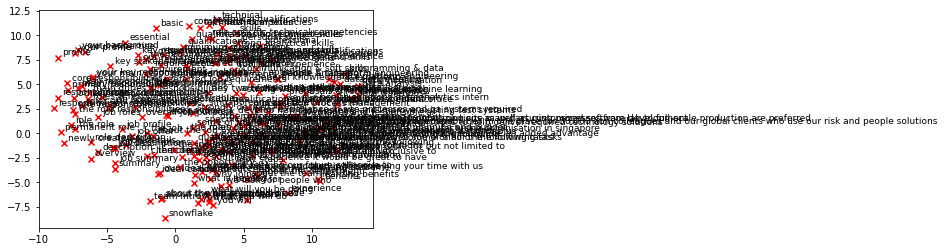

In [66]:
plt.rcParams["figure.figsize"] = (20,20)

for i, type in enumerate(jd_headers_embeddings.keys()):
    x = jd_headers_embeddings_tsne[i][0]
    y = jd_headers_embeddings_tsne[i][1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
plt.show()

In [67]:
from transformers import AutoTokenizer, AutoModel
import torch
from datasets import Dataset

model_name = "distilbert-base-uncased"

tokeniser = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Computes them on the GPU if available, else its on the CPU
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:
encoded_jd_headers = tokeniser(list(sorted_jd_headers), padding=True, truncation=True)

In [69]:
encoded_jd_headers.keys()

dict_keys(['input_ids', 'attention_mask'])

In [70]:
def tokenise(sample_data):
    return tokeniser(sample_data['headers'],padding=True, truncation=True)

In [71]:

# Need to extract the last hidden state of the output of the encoder
def extract_embeddings(batch):
    # place model inputs on the GPU
    # the tokenizer model input names are all of the names of the fields from the tokenizer
    # like input_ids, attention_mask
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokeniser.model_input_names}
    # we use the model to take all of the inputs per batch, generate the output
    # and then use the output to extract the last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # Return vector the the [CLS] token
    # we use numpy as the map function requires it to be in this format
    return {'hidden_state':last_hidden_state[:,0].cpu().numpy()}

In [72]:
pd_jd_headers = pd.DataFrame(list(sorted_jd_headers.keys()))

In [73]:
pd_jd_headers.columns = ['headers']

In [74]:
dataset = Dataset.from_pandas(pd_jd_headers)

In [75]:
dataset

Dataset({
    features: ['headers'],
    num_rows: 282
})

In [76]:
dataset_tokenized = dataset.map(tokenise, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [77]:
dataset

Dataset({
    features: ['headers'],
    num_rows: 282
})

In [78]:
dataset_tokenized

Dataset({
    features: ['headers', 'input_ids', 'attention_mask'],
    num_rows: 282
})

In [79]:
selected_cols = ["input_ids", "attention_mask", "headers"]

dataset_tokenized.set_format("torch", columns=selected_cols)

In [80]:
dataset_last_hidden_state = dataset_tokenized.map(extract_embeddings, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [81]:
dataset_last_hidden_state[0]['hidden_state']

tensor([-6.4203e-02,  1.3685e-01,  6.8550e-02, -2.4462e-01,  5.0352e-03,
        -7.5622e-02,  2.7785e-01,  2.1811e-01, -1.8833e-01, -1.7422e-01,
        -1.7689e-01,  1.3522e-02,  1.2516e-01,  1.7664e-01,  1.9922e-01,
         9.5667e-02, -1.4226e-01,  1.6692e-01,  2.5288e-01, -2.9117e-01,
        -6.5798e-02, -1.6965e-01, -8.7263e-02, -8.2657e-02,  8.4201e-03,
         6.2837e-02,  7.8272e-04,  8.9269e-02,  2.5549e-02,  2.1205e-02,
         9.2591e-02, -1.2564e-02,  6.5711e-02,  5.2823e-02,  1.4236e-01,
         6.8296e-02,  9.4687e-02, -3.9631e-02,  4.1428e-03, -2.0284e-01,
         2.3375e-02,  3.5677e-02,  1.6870e-01,  2.0245e-02,  2.3971e-02,
         1.0180e-01, -1.8076e+00, -2.5814e-01, -1.8954e-01, -9.5522e-02,
         1.3033e-01,  1.2759e-01,  9.4335e-02,  2.3016e-01,  2.7670e-01,
         2.4712e-01, -1.2441e-01,  3.4506e-01,  2.7628e-03,  9.6267e-02,
         2.1791e-01,  2.2954e-01, -1.4716e-01,  1.2638e-01,  1.0748e-01,
         2.7340e-02,  7.3639e-03,  1.7558e-01, -3.1

In [86]:
dataset_last_hidden_state[0]['hidden_state']

tensor([-6.4203e-02,  1.3685e-01,  6.8550e-02, -2.4462e-01,  5.0352e-03,
        -7.5622e-02,  2.7785e-01,  2.1811e-01, -1.8833e-01, -1.7422e-01,
        -1.7689e-01,  1.3522e-02,  1.2516e-01,  1.7664e-01,  1.9922e-01,
         9.5667e-02, -1.4226e-01,  1.6692e-01,  2.5288e-01, -2.9117e-01,
        -6.5798e-02, -1.6965e-01, -8.7263e-02, -8.2657e-02,  8.4201e-03,
         6.2837e-02,  7.8272e-04,  8.9269e-02,  2.5549e-02,  2.1205e-02,
         9.2591e-02, -1.2564e-02,  6.5711e-02,  5.2823e-02,  1.4236e-01,
         6.8296e-02,  9.4687e-02, -3.9631e-02,  4.1428e-03, -2.0284e-01,
         2.3375e-02,  3.5677e-02,  1.6870e-01,  2.0245e-02,  2.3971e-02,
         1.0180e-01, -1.8076e+00, -2.5814e-01, -1.8954e-01, -9.5522e-02,
         1.3033e-01,  1.2759e-01,  9.4335e-02,  2.3016e-01,  2.7670e-01,
         2.4712e-01, -1.2441e-01,  3.4506e-01,  2.7628e-03,  9.6267e-02,
         2.1791e-01,  2.2954e-01, -1.4716e-01,  1.2638e-01,  1.0748e-01,
         2.7340e-02,  7.3639e-03,  1.7558e-01, -3.1

In [87]:
# Lets do some clustering

In [88]:
X_train = dataset_last_hidden_state['hidden_state']

In [89]:
from sklearn.cluster import KMeans

In [90]:
clustering_model = KMeans(n_clusters=3)

clustering_model.fit(X_train)

c:\tools\miniconda3\envs\scrapper-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=3)

In [91]:
labels = clustering_model.predict(X_train)

In [92]:
import matplotlib.pyplot as plt

(array([120.,   0.,   0.,   0.,   0., 104.,   0.,   0.,   0.,  58.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

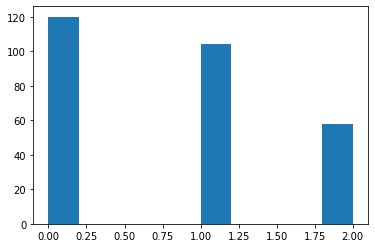

In [93]:
# We appear to have a good spread , lets inspect the outcome
plt.hist(labels)

In [94]:
len(dataset_tokenized['headers'])

282

In [95]:
len(labels)

282

In [96]:
# Clustering based just on the headers may not be effective as the content may not matche with the header
list(zip(dataset_tokenized['headers'], labels))[:50]

[('qualifications', 0),
 ('responsibilities', 0),
 ('preferred qualifications', 0),
 ('job requirements', 0),
 ('requirements', 0),
 ('our ideal candidate', 1),
 ('role specific technical competencies', 0),
 ('job description', 0),
 ('key responsibilities', 0),
 ('regulatory & business conduct', 0),
 ('unorganised_jd', 1),
 ('minimum qualifications', 0),
 ('job responsibilities', 0),
 ('key stakeholders', 0),
 ('risk management', 0),
 ('about the team', 1),
 ("what you'll do", 1),
 ('strategy', 1),
 ('business', 1),
 ('processes', 0),
 ('mix_jd_requirements', 0),
 ('governance', 0),
 ('other responsibilities', 0),
 ('education', 0),
 ('the e-commerce risk control (ecrc) team is missioned', 2),
 ('this role requires a wide variety of strengths and capabilities, including',
  0),
 ('preferred qualification', 1),
 ('internal', 1),
 ('you will', 1),
 ('role responsibilities', 0),
 ('people and talent', 1),
 ('technical', 0),
 ('requirement', 1),
 ('why join us', 1),
 ('team intro', 1),
 ('

Since using embeddings are not useful, at this point we can do a manual mapping for most of the headers. Ultimately we are expecting/wanting/hoping/wishing/praying for two headers: Job Description and Candidate requirements

#### Manual Mapping

- Eliminate headers with no values : I.e Sentences in bold but contain no lists or contains text but no bullet points
- Remove punctuations to get rid of `Job Requirements:` vs `Job Requirements`
- Rename, combine headers to appropriate ones 

End result: we want to have 2 core headers with Job requirements (requirements from the candidate, qualficiations, and Job Responsibilities or Description (JD, or whatever that is demanded from the candidates)

In [130]:
jd_headers_list = ['description','responsibilities','responsibility','scope','purpose',\
    'role','expect','do','accountabilities','activity','work', 'you will']
jd_secondary_headers_list = ['',' ',':','\xa0']
jr_headers_list = ['requirement','skill', 'qualification','attributes','succeed','possess','experience','prefer','education',\
    'certification','mandatory','essential','looking','candidate','expertise','competenc','profile', 'you have']

In [131]:
import copy

TOTAL_JOB_RAW_DATA_COPY = copy.deepcopy(TOTAL_JOB_RAW_DATA)

In [132]:
data_copy = copy.deepcopy(data)

In [133]:
TOTAL_JOB_RAW_DATA_COPY[12][3]

{'responsibilities': 'Responsible for development of NLP technologies in our products.Participate in and support the incubation of new NLP technologies.Participate in research on NLP technologies.',
 'qualifications': "Bachelor's degree or above, majoring in Computer Science, or related fields.Rich experiences and strong skills in development of technologies in some of the following areas,.Natural language understanding.Natural language generation.Knowledge and reasoning.Recommendation and search.Reinforcement learning.Deep learning and representation learning.Machine Translation.Strong analytical and problem-solving skills..Strong computer science and coding skills (e.g. Python/Java/Go/C/C++);.Work and collaborate well with team members;.Senior candidates have the ability to organize and lead teams and projects.."}

In [134]:
def reclassify_JD_headers():
    for row_idx, row in enumerate(TOTAL_JOB_RAW_DATA_COPY):
        jd = []
        jr = []
        others = []
        header_list = row[3].keys()
        for header_idx, header in enumerate(header_list):
            # print(header)
            # print(row[3][header])
            # sometimes something can happen to the first header and get attributed to nothing for example:
            if (header_idx==0) and (header in jd_secondary_headers_list):
                jd.append(row[3][header])
            elif any(sample in header.lower() for sample in jd_headers_list):
                jd.append(row[3][header])
            elif any(sample in header.lower() for sample in jr_headers_list):
                jr.append(row[3][header])
            else:
                others.append([header, row[3][header]])
        #print({'jd':jd,'jr':jr,'others':others})
        TOTAL_JOB_RAW_DATA_COPY[row_idx][3] = {'jd':jd,'jr':jr,'others':others}

In [135]:
reclassify_JD_headers()

In [136]:
TOTAL_JOB_RAW_DATA_COPY[0][3]

{'jd': ['Build Machine Learning models to respond to and mitigate risks in Global Payments products;.Improve modelling infrastructures, labels, features and algorithms towards improving robustness, automation and generalisation, as well as, reduce modelling and operational load on risk adversaries and new product/risk ramping-ups;.Level up the risk Machine Learning expertise excellence in domain areas such as privacy/compliance, interoperability, risk perception, analysis, etc.;.'],
 'jr': ['Bachelor degree or above in Computer Science, Statistics, Mathematics or other related majors;.Proficient in Python, Java or Scala and big data tools such as SQL / Hive / Spark, etc.;.3 years and above of Machine Learning experience, preferably with domain experiences in Trust & Safety, Risk management, Anti Fraud;.Domain experiences in one of these fields is preferred: trust and safety, risk management, fraud, anti-fraud, etc..Experienced in Machine Learning and Deep Learning models;.'],
 'others'

In [137]:
TOTAL_JOB_RAW_DATA_COPY[155][3]

{'jd': [],
 'jr': [],
 'others': [['software lead (machine vision/semiconductor/ image processing)',
   'Lead a team of software engineers in assigned projects.Design and develop vision inspection system for semiconductor equipment, and help define software architecture.Continuous improvement for existing and new semiconductor machines.Debug, troubleshoot and resolve customer issues.Guide junior software engineers.Degree in Electrical and Electronic Engineering or Computer Science.Strong working experience in Computer Vision and Image processing.Experience in leading a team.Experience in 3D Vision techniques, GUI design and Computer Graphic would be a plus.Proficient in C++ Programming Language and Windows programming skill.Strong interpersonal and communication skills.']]}

Inspect others

In [138]:
def inspect_JD_others():
    """checks the JD for the other category and returns a dictionary containing them
    """
    other_section = {}
    for row_idx, row in enumerate(TOTAL_JOB_RAW_DATA_COPY):
        header_list = row[3]
        others = header_list['others']
        if len(others)!=0:
            other_section[row_idx] = others
    return other_section

In [139]:
other_section = inspect_JD_others()

In [140]:
other_section

{0: [['why join us',
   "To protect ByteDance users who are using Global Payments' service, including live stream creators and users, e-commerce buyers and sellers;.To provide a safe payment experiences on our platforms by securing the integrity of our payments ecosystem, building infrastructures, platforms and technologies.To collaborate with multiple cross-functional teams and stakeholders to provide exceptional values to our customers."]],
 4: [['about the job',
   'Working with the raw image data, research, develop, evaluate, and optimize various computer vision and deep learning models for different automation applications.Exploring and visualizing data acquired to identify features, and differences in data distribution that could improve performance when deploying the model in the real world.Deploy machine vision models on edge devices after optimization to meet customer requirements and maintain them to later improve to address additional customer requirements in the future.']],

In [142]:
jd_list = []
jr_list = []
others_list = []

for row_idx, row in enumerate(TOTAL_JOB_RAW_DATA_COPY):
    free_format_section = row[3]
    if len(free_format_section['jd']) >0 :
        jd_list.append(free_format_section['jd'][0])
    else:
        jd_list.append("None")
    if len(free_format_section['jr']) >0 :
        jr_list.append(free_format_section['jr'][0])
    else:
        jr_list.append("None")
    if len(free_format_section['others']) >0 :
        others_list.append(free_format_section['others'])
    else:
        others_list.append("None")

assert (len(jd_list)==len(jr_list)==len(others_list))

In [143]:
data.update({'job_description':jd_list,'job_requirements':jr_list,'others':others_list})

In [144]:
for key in data.keys():
    print(f"Length of {key} : {len(data[key])}")

Length of position : 1157
Length of company_name : 1157
Length of career_level : 1157
Length of qualifcation : 1157
Length of job_type : 1157
Length of job_specialisations : 1157
Length of company_overview : 1157
Length of url : 1157
Length of location : 1157
Length of low_salary : 1157
Length of high_salary : 1157
Length of post_date : 1157
Length of job_description : 1157
Length of job_requirements : 1157
Length of others : 1157


In [145]:
data_pd = pd.DataFrame.from_dict(data)

In [146]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   position             1157 non-null   object        
 1   company_name         1157 non-null   object        
 2   career_level         1157 non-null   object        
 3   qualifcation         1157 non-null   object        
 4   job_type             1157 non-null   object        
 5   job_specialisations  1157 non-null   object        
 6   company_overview     1157 non-null   object        
 7   url                  1157 non-null   object        
 8   location             1157 non-null   object        
 9   low_salary           1157 non-null   object        
 10  high_salary          1157 non-null   object        
 11  post_date            1157 non-null   datetime64[ns]
 12  job_description      1157 non-null   object        
 13  job_requirements     1157 non-nul

In [148]:
# We can see that the scrape and preprocessing is not perfect, there are some with incomplete information
# Furthermore we still need to clean up the Job title, job description and job requirements
data_pd.sample(5,random_state=RANDOM_STATE)

,position,company_name,career_level,qualifcation,job_type,job_specialisations,company_overview,url,location,low_salary,high_salary,post_date,job_description,job_requirements,others
940,"Snr Specialist Biz Transformation, Data Migration",ASM Front-End Manufacturing Singapore Pte Ltd,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Professional Degree",Full-Time,"Computer/Information Technology, IT-Network/Sys/DB Admin","\n\tIn 1968, at the very outset of the global semiconductor industry, entrepreneur Arthur del Prado established ASM in the Netherlands. Mr Del Prado then served as President, Chief Executive Officer and Chairman of the Management Board of ASM International until his retirement, in 2008. Acclaimed as the ""father of the European semiconductor equipment industry”, his contributions to the industr...",http://www.jobstreet.com.sg/en/job/snr-specialist-biz-transformation-data-migration-10270617?jobId=jobstreet-sg-job-10270617&sectionRank=377&token=0~9232a8db-1b04-45af-a55b-b7ddd2a5f148&fr=SRP%20Job%20Listing,unspecified,unspecified,unspecified,2022-12-21,None,None,"[[join us on our journey to unleash the power of an open mind. be part of our exciting future and apply today!, Defining data migration strategy for master data and transaction data.Defining data migration approach & process, including mock and production loads, to ensure successful production migration with minimum errors.Recommending and deploying ETL (Extraction, Transformation, Load) and v..."
265,AI Architect (Digital),Mediacorp Pte Ltd,Senior Executive,"Diploma, Advanced/Higher/Graduate Diploma, Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Software","\n\nMediacorp is Singapore’s leading media company with the most complete range of platforms, spanning television, radio, newspapers, magazines, movies, digital and out-of-home media.\n\t\t \n\n\t\tIt pioneered the development of Singapore’s broadcasting industry, with the broadcast of Radio in 1936 and Television in 1963.\n\n\t\tToday, Mediacorp has over 50 products and brands in four languag...",http://www.jobstreet.com.sg/en/job/ai-architect-digital-10232479?jobId=jobstreet-sg-job-10232479&sectionRank=276&token=0~028e1606-4f5f-41e8-a322-949f17f3c36b&fr=SRP%20Job%20Listing,unspecified,unspecified,unspecified,2022-12-17,"Partner and collaborate with both Internal and External stakeholders to dive deep into data, doing analysis, discovering root causes, and designing long-term AI/ML solutions & Roadmaps.Drive the delivery of AI/ML project from beginning to end, including understanding business requirements, developing architecture, aggregating data, exploring data, building & validating predictive models, and d...","Bachelor's degree in Computer Science, Computer Engineering, AI or related fields.5+ years of experience with architecture, design and implementation of AI/ML technologies.Technical depth in shaping and designing AI/ML architectures and infrastructure.Familiar with Cloud Infrastructures, Kubernetes, Docker, GPU, TensorFlow, Pytorch & other Opensource AI/ML framework and libraries.Experience wi...",None
109,"Machine Learning Engr., TikTok Search",TikTok,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Software","TikTok is the leading destination for short-form mobile video. Our mission is to inspire creativity and bring joy. TikTok is a global short-form mobile video platform that allows you to express yourself by creating content. It gives rise to engaging, interactive challenges and trending topics in which anyone can participate. TikTok aims to capture and showcase the world's creativity, knowledge...",http://www.jobstreet.com.sg/en/job/machine-learning-engr.-tiktok-search-urgent-worknow-10308024?jobId=jobstreet-sg-job-10308024&sectionRank=114&token=0~2d20fa49-9650-4bbc-b087-8815b24611d8&fr=SRP%20Job%20Li

# EDA

In [151]:
# Remove duplicates by checking against the position name and the company

data_pd_no_dup = data_pd.drop_duplicates(subset=['position','company_name'])

In [152]:
# We have 914 entries remaining which means 243 are duplicates
data_pd_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   position             914 non-null    object        
 1   company_name         914 non-null    object        
 2   career_level         914 non-null    object        
 3   qualifcation         914 non-null    object        
 4   job_type             914 non-null    object        
 5   job_specialisations  914 non-null    object        
 6   company_overview     914 non-null    object        
 7   url                  914 non-null    object        
 8   location             914 non-null    object        
 9   low_salary           914 non-null    object        
 10  high_salary          914 non-null    object        
 11  post_date            914 non-null    datetime64[ns]
 12  job_description      914 non-null    object        
 13  job_requirements     914 non-null 

In [153]:
data_pd_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   position             914 non-null    object        
 1   company_name         914 non-null    object        
 2   career_level         914 non-null    object        
 3   qualifcation         914 non-null    object        
 4   job_type             914 non-null    object        
 5   job_specialisations  914 non-null    object        
 6   company_overview     914 non-null    object        
 7   url                  914 non-null    object        
 8   location             914 non-null    object        
 9   low_salary           914 non-null    object        
 10  high_salary          914 non-null    object        
 11  post_date            914 non-null    datetime64[ns]
 12  job_description      914 non-null    object        
 13  job_requirements     914 non-null 

In [154]:
# Let's discover what are the entries with complete information 

complete_salary_condition = (data_pd_no_dup.loc[:,'low_salary']!="unspecified") & (data_pd_no_dup.loc[:,'high_salary']!="unspecified")
complete_jd_jr_condition = (data_pd_no_dup.loc[:,'job_description']!="None") & (data_pd_no_dup.loc[:,'job_requirements']!="None")

print(f"With complete salary condition : {len(data_pd_no_dup[complete_salary_condition])}")
print(f"With complete jd and jr : {len(data_pd_no_dup[complete_jd_jr_condition])}")
print(f"With complete information condition : {len(data_pd_no_dup[complete_salary_condition & complete_jd_jr_condition])}")

With complete salary condition : 62
With complete jd and jr : 622
With complete information condition : 34


Out of the initial 1157, we have 

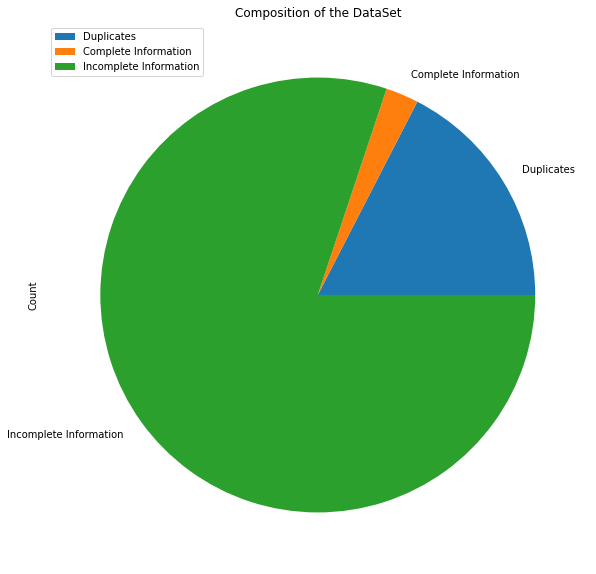

In [161]:
pd.DataFrame.from_dict({'Duplicates':1157-914,'Complete Information':34,'Incomplete Information':1151-34}, orient='index')\
    .rename(columns={0:"Count"})\
        .plot(kind='pie', y='Count', figsize=(10,10), title="Composition of the DataSet")
plt.legend(loc='upper left')

In [156]:
complete_data_pd = data_pd_no_dup[complete_salary_condition & complete_jd_jr_condition]

In [157]:
complete_data_pd.head()

,position,company_name,career_level,qualifcation,job_type,job_specialisations,company_overview,url,location,low_salary,high_salary,post_date,job_description,job_requirements,others
8,R&D Engineer (Artificial Intelligence and Machine Learning),LRDTECH PTE. LTD.,Junior Executive,"Bachelor's Degree, Post Graduate Diploma, Professional Degree, Master's Degree",Full-Time,"Computer/Information Technology, IT-Software",We are a Singapore-based technology company that creates breakthrough Artificial Intelligence (AI) technologies backed by a global leader in the energy sector. We are hiring from the best and brightest scientists and engineers to conduct applied R&D and solve the most challenging problems in high-stakes projects.,http://www.jobstreet.com.sg/en/job/r-d-engineer-artificial-intelligence-and-machine-learning-10301713?jobId=jobstreet-sg-job-10301713&sectionRank=10&token=0~88711830-adbe-4cec-891d-43a0b8e768aa&fr=SRP%20Job%20Listing,West,"5,000","8,000",2023-01-05,Conducting applied R&D on core technologies of the company..Designing and developing software libraries running on the company’s HPC infrastructure..Applying your skills and knowledge to affect high-profile engineering projects that result in critical real world impacts..,"BSc/MSc in Computing, Science or Engineering (with a GPA of at least 4.0, please send transcript in application)..Minimum 2 to 3 years of relevant software development and/or data science experience (work attachments or internships can be included).Strong programming skills in Python/NumPy, C or C++..Proficiency in development tools such as git, Linux Shell Scripting, vim/emacs, etc..Excellent...","[[why join lrd?, You are always presented with new challenges to solve intellectually stimulating problems. The work never gets stale, mundane or boring..Continuous learning opportunities to develop your technical expertise in many subfields of AI, ML, HPC, geoscience, engineering, etc..Have your work recognised with publication opportunities in top scientific conferences and journals..Be rewa..."
15,Data Engineer,Avensys Consulting Pte Ltd,Senior Executive,Not Specified,Full-Time,"Computer/Information Technology, IT-Software","\n\tAvensys is a leader in providing technology enabled business solutions and services. Since inception, Avensys has helped clients use IT more efficiently to improve their operations and profitability, focus on core competencies and achieve business results such as increased agility, innovation and profitable growth. Our in-depth technical knowledge coupled with industry experience and our u...",http://www.jobstreet.com.sg/en/job/data-engineer-10308346?jobId=jobstreet-sg-job-10308346&sectionRank=17&token=0~88711830-adbe-4cec-891d-43a0b8e768aa&fr=SRP%20Job%20Listing,unspecified,"5,000","7,000",2023-01-05,"Implementing Data Architecture/ Data modelling for data platform and Analytics..Responsible for the technical design and development of Analytics and big data systems including ETL, data transformations..Define and govern banking logical model and data platform best practices and standards to include software development practices, design styles and software deployment..Facilitate the discover...","At least 6 to 8 years of working experience, preferably in banking environments.Familiarity with key technologies and concepts, e.g. Hadoop, Hive, Spark, Scala, Java and Impala are necessary.Familiarity with Cloudera echo systems..Candidate with experience in Analytics and big data architecture..Familiarity with key technologies and concepts, SQL & Big Data..Knowledge of products in Banking an...",None
16,Data Scientist (AI / Machine Learning),Talent Trader Group Pte Ltd,Junior Executive,"Professional Certificate/NiTEC, Diploma, Advanced/Higher/Graduate Diploma, Bachelor's Degree, Post Graduate Diploma, Professional Degree",Full-Time,"Computer/Information Technology, IT-Network/Sys/DB Admin",\n\tOur business philosophy stems from our belief that Mid management are vital to all organi